# Stimulation example

This notebook will give you a simple example of how to construct a stimulus and apply it as an input current to the excitatory population of the `aln` model.

In [1]:
# change to the root directory of the project
import os

if os.getcwd().split("/")[-1] in ["examples", "dev"]:
    os.chdir("..")

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
try:
    import matplotlib.pyplot as plt
except ImportError:
    import sys
    !{sys.executable} -m pip install matplotlib
    import matplotlib.pyplot as plt

# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy
# Let's import the aln model
from neurolib.models.aln import ALNModel

## Let's talk stimuli

`neurolib` offers a range of external stimuli you can apply to your models. These range from basic noise processes like Wiener process or Ornstein Uhlenbeck, to driving inputs in the form of sinousoids, rectified inputs etc. All stimuli are based on `ModelInput` class, and are available in the `neurolib.utils.stimulus` subpackage. In the following we will detail implemented inputs and also an easy way how to implement your own stimulus.

All inputs are initialised as classes and then all of them has three functions for actual generation of the input:
- `as_array(duration, dt)` - will return numpy array
- `as_cubic_splines(duration, dt)` - will return a CubicHermiteSpline object, which represents a spline representation of the given input - useful for `jitcdde` backend in `MultiModel`
- `to_model(model)` - probably the easiest one - infers the duration, dt and number of nodes from the initialised neurolib's model and returns numpy array of appropriate shape

Each input has a bit different init function, however all of them include `num_iid` and `seed` parameters. `num_iid` controls how many independent realizations are returned (for e.g. sinusoidal input this just copies the same input over, but for random inputs it actually creates a different realization).

### Zero input - for convenience
You'll probably never use it, but you know, it's there...

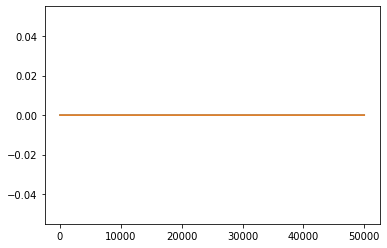

In [3]:
duration = 5000  # 5 seconds
dt = 0.1
inp = stim.ZeroInput(num_iid=2).as_array(duration, dt)
plt.plot(inp)

### WienerProcess
Basic Wiener process $dW$, i.e. random numbers drawn from $N(0, \sqrt{dt})$

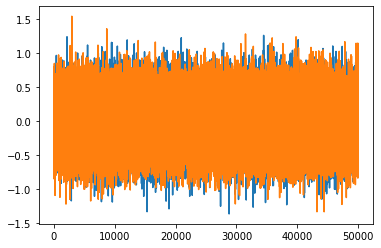

In [4]:
inp = stim.WienerProcess(num_iid=2).as_array(duration, dt)
plt.plot(inp)

### Ornstein-Uhlenbeck process
Ornstein-Uhlenback process, i.e. $\dot{x} = (\mu - x)/\tau \cdot dt + \sigma\cdot dW$

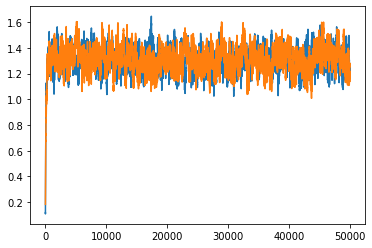

In [5]:
inp = stim.OrnsteinUhlenbeckProcess(mu=1.3, sigma=0.04, tau=10.0, num_iid=2).as_array(
    duration, dt
)
plt.plot(inp)

### Step input
A bit fancy name, it's just a bias, or DC offset.

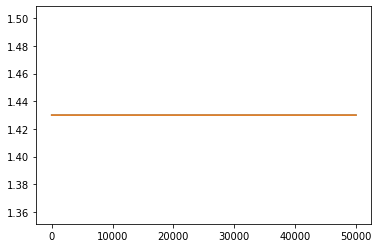

In [6]:
inp = stim.StepInput(step_size=1.43, num_iid=2).as_array(duration, dt)
plt.plot(inp)

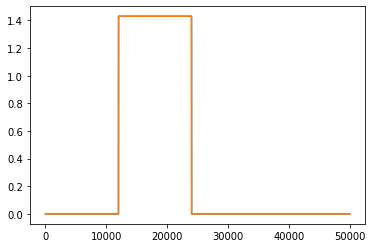

In [7]:
# you can also set stim_start and stim_end - in ms
inp = stim.StepInput(
    step_size=1.43, stim_start=1200, stim_end=2400, num_iid=2
).as_array(duration, dt)
plt.plot(inp)

### Sinusoidal input
Or the famous AC offset.

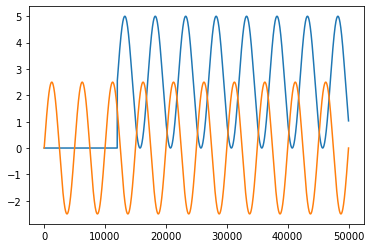

In [8]:
# period in ms; nonnegative=True shifts input by its amplitude (as a DC bias)
inp = stim.SinusoidalInput(
    amplitude=2.5, period=500.0, stim_start=1200, nonnegative=True
).as_array(duration, dt)
inp2 = stim.SinusoidalInput(amplitude=2.5, period=500.0, nonnegative=False).as_array(
    duration, dt
)
plt.plot(inp)
plt.plot(inp2)

### Square input
More rought AC offset.

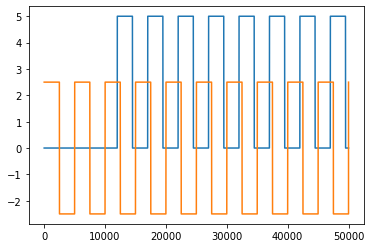

In [9]:
# period in ms; nonnegative=True shifts input by its amplitude (as a DC bias)
inp = stim.SquareInput(
    amplitude=2.5, period=500.0, stim_start=1200, nonnegative=True
).as_array(duration, dt)
inp2 = stim.SquareInput(amplitude=2.5, period=500.0, nonnegative=False).as_array(
    duration, dt
)
plt.plot(inp)
plt.plot(inp2)

### Linear ramp
When you need to go slowly but surely

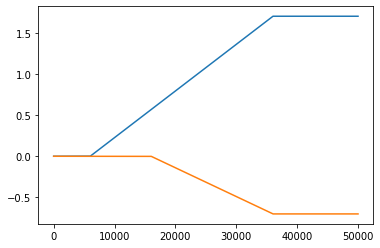

In [10]:
# ramp_length in ms
inp = stim.LinearRampInput(inp_max=1.7, ramp_length=3000, stim_start=600).as_array(
    duration, dt
)
inp2 = stim.LinearRampInput(inp_max=-0.7, ramp_length=2000, stim_start=1600).as_array(
    duration, dt
)
plt.plot(inp)
plt.plot(inp2)

### Exponential input
When you need to go FAST.

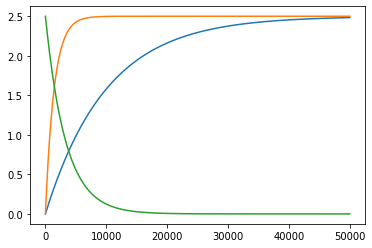

In [11]:
inp = stim.ExponentialInput(inp_max=2.5, exp_coef=5.0, exp_type="rise").as_array(
    duration, dt
)
inp2 = stim.ExponentialInput(inp_max=2.5, exp_coef=35.0, exp_type="rise").as_array(
    duration, dt
)
inp3 = stim.ExponentialInput(inp_max=2.5, exp_coef=15.0, exp_type="decay").as_array(
    duration, dt
)
plt.plot(inp)
plt.plot(inp2)
plt.plot(inp3)

### RectifiedInput
A mix of inputs that start with negative step, then we have exponential rise and subsequent decay to zero. Useful for detecting bistability

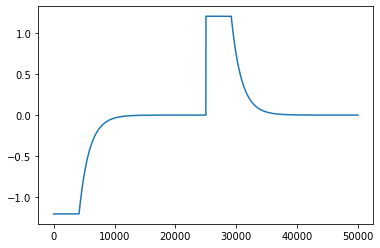

In [12]:
inp = stim.RectifiedInput(amplitude=1.2).as_array(duration, dt)
plt.plot(inp)

## Operations on stimuli
Sometimes you need or want to sum or concatenate the inputs together to create some wild beasts. This is easy with neurolib's stimuli. All of them allow two operations: `+` to sum them up and `&` to concatenate them (one after another). In the cells below we will show some combinations you can do.

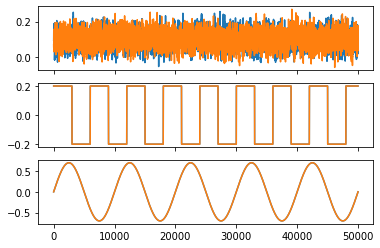

In [13]:
# let's create some basic inputs
ou = stim.OrnsteinUhlenbeckProcess(mu=0.1, sigma=0.04, tau=2.0, num_iid=2)
sq = stim.SquareInput(amplitude=0.2, period=600.0, num_iid=2, nonnegative=False)
sin = stim.SinusoidalInput(amplitude=0.7, period=1000.0, nonnegative=False, num_iid=2)

_, axs = plt.subplots(nrows=3, ncols=1, sharex=True)
for i, inp in enumerate([ou, sq, sin]):
    axs[i].plot(inp.as_array(duration, dt))

### Sum

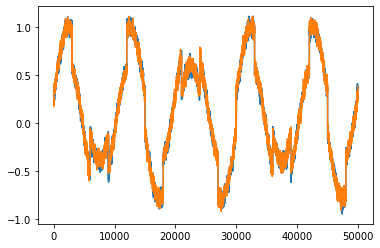

In [14]:
summed = ou + sq + sin
plt.plot(summed.as_array(duration, dt))

### Concatenation

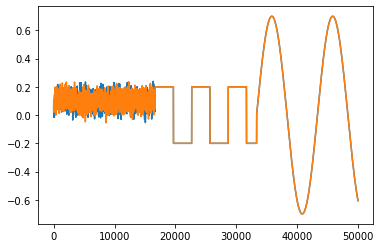

In [15]:
# same lengths - use &
conc = ou & sq & sin
plt.plot(conc.as_array(duration, dt))

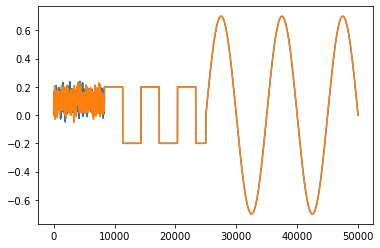

In [16]:
# can also do different length ratios, but for this you need to call ConcatenatedInput directly
conc = stim.ConcatenatedInput([ou, sq, sin], length_ratios=[1, 2, 3])
plt.plot(conc.as_array(duration, dt))

### Mixing the operations, a.k.a. the beast mode
Unless you go really full retard, everything should work nicely and you should be able to use as many `+` and `&` as you want.

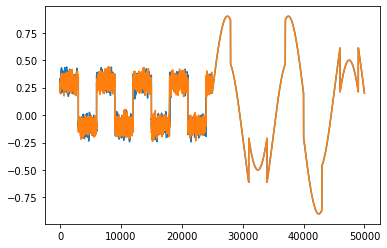

In [17]:
beast = (ou + sq) & (sq + sin)
plt.plot(beast.as_array(duration, dt))

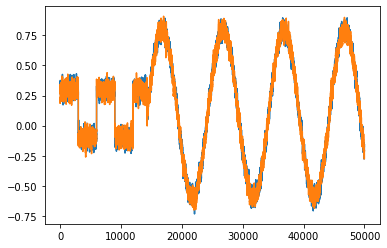

In [18]:
beast = stim.ConcatenatedInput([ou + sq, ou + sin], [2, 5])
plt.plot(beast.as_array(duration, dt))

## Creating custom stimulus
Sometimes you need a different noise process or different stimulus to drive your model. Fortunately, creating new stimulus is very easy and you can build your library of model inputs. There are only three steps:
1. subclass `stim.ModelInput` for basic input or `stim.StimulusInput` for the option to set stim_start and stim_end
2. define `__init__()` with necessary parameters and set the attributes
3. define `generate_input(duration, dt)` function, which returns numpy array as [times, num_iid]
and that's it. Everything else is taken care of. Your new input will be also ready to undergo operations like `+` and `&`.

Below we will implement new stimulus - a noise representing a Poission spike train with exponential kernel.

In [19]:
class PoissonNoiseWithExpKernel(stim.StimulusInput):
    """
    Poisson noise with exponential kernel.
    By subclassing the `StimulusInput` we have an option to select stim_start and stim_end.
    """

    def __init__(
        self, freq, amp, tau_syn, stim_start=None, stim_end=None, num_iid=1, seed=None
    ):
        # save parameters as attributes
        self.freq = freq
        self.amp = amp
        self.tau_syn = tau_syn
        # pass other params to parent class
        super().__init__(
            stim_start=stim_start, stim_end=stim_end, num_iid=num_iid, seed=seed
        )

    def generate_input(self, duration, dt):
        # this is a helper function that creates self.times vector
        self._get_times(duration=duration, dt=dt)
        # do the magic here: prepare output vector
        x = np.zeros((self.times.shape[0], self.num_iid))
        # compute total number of spikes
        total_spikes = int(self.freq * (self.times[-1] - self.times[0]) / 1000.0)
        # randomly posit spikes to the output vector
        spike_indices = np.random.choice(
            len(x), (total_spikes, self.num_iid), replace=True
        )
        x[spike_indices, np.arange(x.shape[1])[None, :]] = 1.0
        # create exponential kernel
        time_spike_end = -self.tau_syn * np.log(0.001)
        arg_spike_end = np.argmin(np.abs(self.times - time_spike_end))
        spike_kernel = np.exp(-self.times[:arg_spike_end] / self.tau_syn)
        # convolve over dimensions
        x = np.apply_along_axis(np.convolve, axis=0, arr=x, v=spike_kernel, mode="same")
        # self._trim_stim_input takes care of trimming the stimulus based on stim_start and stim_end
        return self._trim_stim_input(x * self.amp)

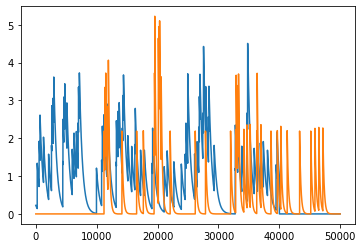

In [20]:
# test ride
inp = PoissonNoiseWithExpKernel(
    freq=20.0, amp=1.2, tau_syn=50.0, num_iid=1, stim_end=4000
).as_array(duration, dt)
inp2 = PoissonNoiseWithExpKernel(
    freq=10.0, amp=2.2, tau_syn=20.0, num_iid=1, stim_start=1000
).as_array(duration, dt)
plt.plot(inp)
plt.plot(inp2)

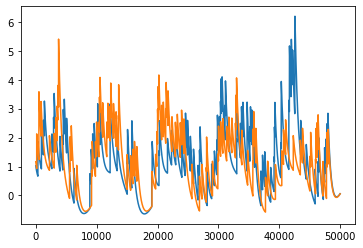

In [21]:
# sum and concat test
pois = PoissonNoiseWithExpKernel(freq=20.0, amp=1.2, tau_syn=50.0, num_iid=2)

summed = pois + sin
plt.plot(summed.as_array(duration, dt))

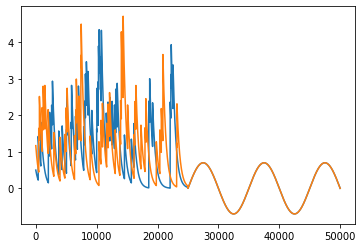

In [22]:
concat = pois & sin
plt.plot(concat.as_array(duration, dt))

## Using stimuli in `neurolib`
First, we initialize a single node.

In [23]:
model = ALNModel()
model.params["duration"] = 5 * 1000
model.params["sigma_ou"] = 0.2  # we add some noise

After creating a base for stimulus, we can simply call `to_model(model)` function and our stimulus is generated.

In [24]:
stimulus = stim.SinusoidalInput(amplitude=1.0, nonnegative=False, period=1000.).to_model(model)
print(stimulus.shape) # neurolib does [nodes x times]

(1, 50000)


The stimulus is then set as an input current parameter to the model. The parameter that models a current that goes to the excitatory population is called `ext_exc_current`. For the inhibitory population, we can use `ext_inh_current`. We can also set a firing rate input, that will then be integrated over the synapses using the parameter `model.params['ext_exc_rate']`.

In [25]:
model.params["ext_exc_current"] = stimulus
model.run()

When we plot the timeseries, we can see that the oscillatory activity locks to the stimulus.

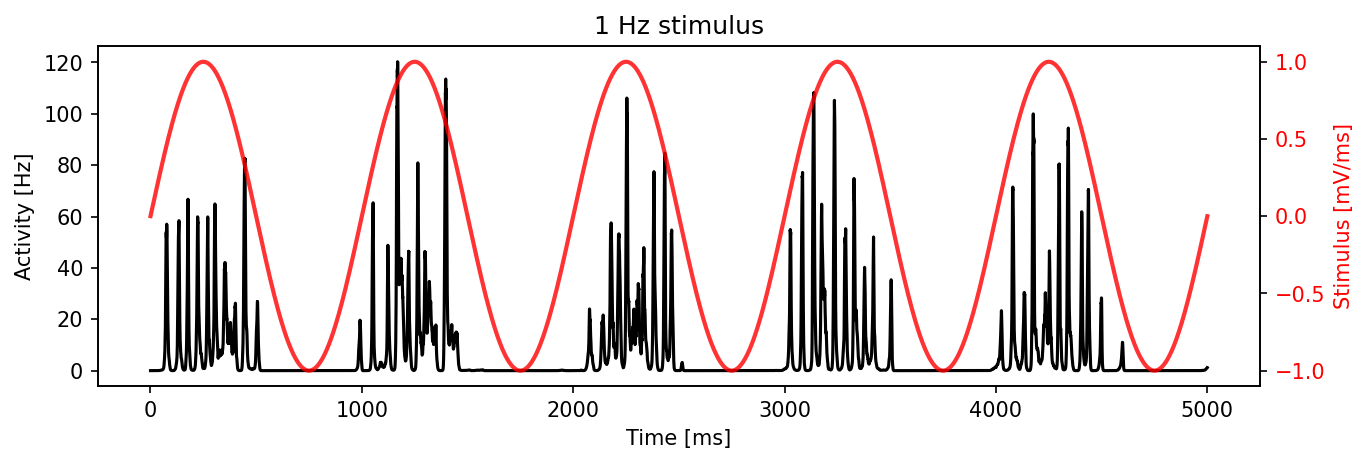

In [26]:
plt.figure(figsize=(10, 3), dpi=150)
plt.title("1 Hz stimulus")
ax1 = plt.gca()
ax1.plot(model.t, model.output.T, c="k")
ax2 = plt.gca().twinx()
ax2.plot(model.t, stimulus.squeeze(), lw=2, c="r", alpha=0.8)
ax1.set_xlabel("Time [ms]")
ax1.set_ylabel("Activity [Hz]")
ax2.set_ylabel("Stimulus [mV/ms]", color="r")
ax2.set_ylabel("Stimulus [mV/ms]", color="r")
ax2.tick_params(axis="y", labelcolor="r")

## Brain network stimulation

In [27]:
from neurolib.utils.loadData import Dataset

ds = Dataset("hcp")

In [28]:
model = ALNModel(Cmat=ds.Cmat, Dmat=ds.Dmat)

# we chose a parameterization in which the brain network oscillates slowly
# between up- and down-states

model.params["mue_ext_mean"] = 2.56
model.params["mui_ext_mean"] = 3.52
model.params["b"] = 4.67
model.params["tauA"] = 1522.68
model.params["sigma_ou"] = 0.40

model.params["duration"] = 0.2 * 60 * 1000

In [29]:
def plot_output_and_spectrum(model, individual=False, vertical_mark=None):
    """A simple plotting function for the timeseries
    and the power spectrum of the activity.
    """
    fig, axs = plt.subplots(
        1, 2, figsize=(8, 2), dpi=150, gridspec_kw={"width_ratios": [2, 1]}
    )
    axs[0].plot(model.t, model.output.T, lw=1)
    axs[0].set_xlabel("Time [ms]")
    axs[0].set_ylabel("Activity [Hz]")

    frs, powers = func.getMeanPowerSpectrum(model.output, dt=model.params.dt)
    axs[1].plot(frs, powers, c="k")

    if individual:
        for o in model.output:
            frs, powers = func.getPowerSpectrum(o, dt=model.params.dt)
            axs[1].plot(frs, powers)

    axs[1].set_xlabel("Frequency [Hz]")
    axs[1].set_ylabel("Power")

    plt.show()

### Without stimulation

In [30]:
model.run(chunkwise=True)

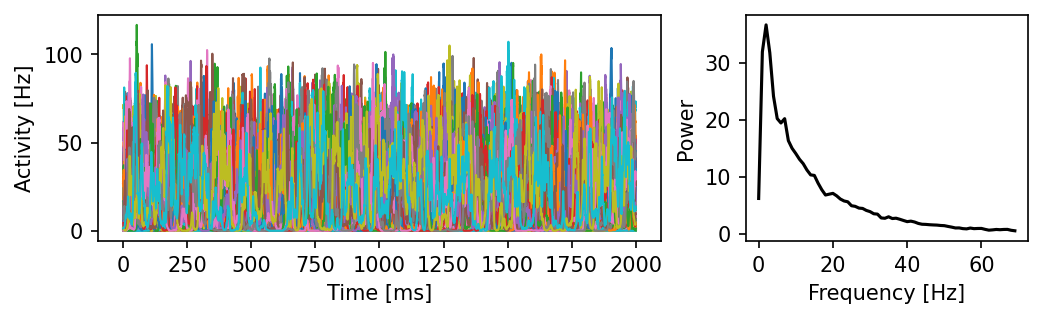

In [31]:
plot_output_and_spectrum(model)

### Constructing a stimulus

`neurolib` helps you to create a few basic stimuli out of the box using the function `stimulus.construct_stimulus()`.

In [32]:
# construct a stimulus
# we want 1-dim input - to all the nodes - 25Hz
ac_stimulus = stim.SinusoidalInput(amplitude=0.2, period=(1000./25), num_iid=1).to_model(model)
print(ac_stimulus.shape)

# this stimulus is 1-dimensional. neurolib will threfore automatically apply it to *all nodes*.
model.params["ext_exc_current"] = ac_stimulus * 5.0

(1, 120000)


In [33]:
model.run(chunkwise=True)

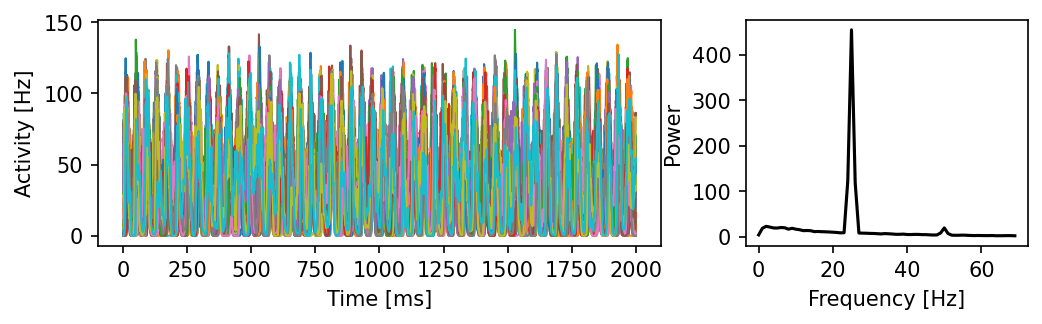

In [34]:
plot_output_and_spectrum(model)

### Focal stimulation

In the previous example, the stimulus was applied to *all nodes* simultaneously. We can also apply stimulation to a specific set of nodes.

In [35]:
# now we create multi-d input of 25Hz
ac_stimulus = stim.SinusoidalInput(amplitude=0.2, period=(1000./25), num_iid=model.params.N).to_model(model)
print(ac_stimulus.shape)

# We set the input to a bunch of nodes to zero.
# This will have the effect that only nodes from 0 to 4 will be sitmulated!
ac_stimulus[5:, :] = 0

# multiply the stimulus amplitude
model.params["ext_exc_current"] = ac_stimulus * 5.0

(80, 120000)


In [36]:
model.run(chunkwise=True)

We can see that the spectrum has a peak at the frequency we stimulated with, but only in a subset of nodes (where we stimulated).

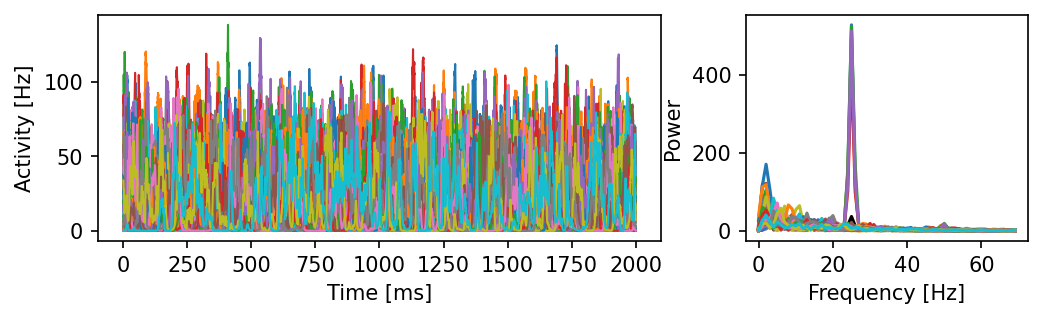

In [37]:
plot_output_and_spectrum(model, individual=True)